# About

Comparing theoretical analysis with numeric results in a simplified 2-dimensional Kuramoto system with adaptive delays and no
self-feedback interactions.

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.transforms as tsfm
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Data files
name_folder = 'matlab2D_1'
name_file = 'gain_30_num_1'

# Directory
dir_main = os.getcwd()
dir_folder = os.path.join(dir_main, 'data', name_folder)
dir_mat = os.path.join(dir_folder, name_file)

# Import using Scipy
dict_mat = sio.loadmat(dir_mat)

# Import Data

In [3]:
# Solution
sol = {}
sol['t'] = np.reshape(dict_mat['t'], -1)
sol['y'] = dict_mat['y']
sol['yp'] = dict_mat['yp']

sol['tau'] = dict_mat['tau']
sol['taup'] = dict_mat['taup']

# Parameters
sol['g'] = dict_mat['g'][0,0]
sol['omega0'] = dict_mat['omega0'][0,0]
sol['Delta0'] = dict_mat['Delta0'][0,0]

sol['gain'] = dict_mat['gain'][0,0]
sol['tau0'] = np.reshape(dict_mat['tau0'], -1)

sol['tf'] = dict_mat['tf'][0,0]

# Processing


## Numerical Results

In [4]:
# Asymptotic percentage
asy = 0.1

# Compute the global frequency:
arr_omega = asylib.weight_avg(sol['t'], sol['yp'], asy)
Omega = np.sum(arr_omega) / arr_omega.size

Omega_vars = asylib.weight_avg(sol['t'], (sol['yp'] - Omega)**2, asy)
Omega_var = np.sum(Omega_vars)

# Get array of asymptotic phases:
arr_lin = Omega*sol['t']
arr_lin = arr_lin[:,None]

arr_phases = sol['y'] - arr_lin
asy_phases = asylib.weight_avg(sol['t'], arr_phases, asy)

# Variance
phase_vars = asylib.weight_avg(sol['t'], (arr_phases - asy_phases)**2, asy)
phase_var = np.sum(phase_vars)

## Numerical Results (graph)

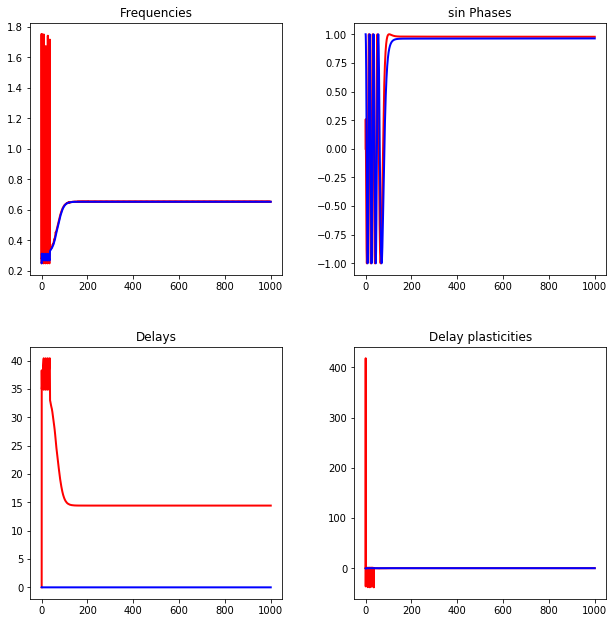

In [5]:
# Configure plots
fig, ax = plt.subplots(4, figsize=(10,10))

# [left, bottom, width, height] 
bbox0 = [0.1, 0.1, 0.35, 0.35]
bbox1 = [0.55, 0.1, 0.35, 0.35]
bbox2 = [0.1, 0.55, 0.35, 0.35]
bbox3 = [0.55, 0.55, 0.35, 0.35]

# Set ax positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)

# Titles
ax[0].set_title('Delays')
ax[1].set_title('Delay plasticities')
ax[2].set_title('Frequencies')
ax[3].set_title('sin Phases')

# Figure options
pltopts = {'linewidth': 2.0,
           'alpha': 1.0,
          }

ax[0].plot(sol['t'], sol['tau'], **pltopts)
ax[1].plot(sol['t'], sol['taup'], **pltopts)
ax[2].plot(sol['t'], sol['yp'], **pltopts)
ax[3].plot(sol['t'], np.sin(arr_phases), **pltopts)

# Set colours
for i in range(len(ax)):
    ax[i].lines[0].set_color('red')
    ax[i].lines[1].set_color('blue')

## Theoretical Roots

In [6]:
# Fixed-point functions
Omega_fun = lambda Omega: funlib.Omega2D(Omega, sol['tau0'], sol)[0]
Delta_fun = lambda Omega: funlib.Omega2D(Omega, sol['tau0'], sol)[1]

# Parameters
w0 = sol['omega0']
g = sol['g']
tau0 = sol['tau0']

# Get all roots of Omega_fun in region
Omega_roots = rootlib.root_on_interval(Omega_fun, w0-g/2, w0+g/2, steps=500)
Delta_roots = np.zeros(Omega_roots.size)

for i in range(Omega_roots.size):
    Delta_roots[i] = Delta_fun(Omega_roots[i])
    
# Find where numerical solution is closest
ind_sol = np.argmin(np.abs(Omega_roots - Omega))
ind_Delta = np.argmin(np.abs(Delta_roots - sol['Delta0']))

# Print stats
print("Numerical freq = " + str(Omega))
print("Numerical phase diff = " + str(asy_phases[1] - asy_phases[0]))
print("Theoretical freq = " + str(Omega_roots[ind_sol]))
print("Theoretical phase diff = " + str(Delta_roots[ind_sol]))
print("Starting phase diff = " + str(sol['Delta0']))
print("Closest theoretical phase diff = " + str(Delta_roots[ind_Delta]))
print("Closest phase diff agrees with result: " + str(ind_sol == ind_Delta))

Numerical freq = 0.653309687370985
Numerical phase diff = 0.4805462874686661
Theoretical freq = 0.6533032016346197
Theoretical phase diff = 0.4805448631509235
Starting phase diff = 1.5707963267948966
Closest theoretical phase diff = 0.4805448631509235
Closest phase diff agrees with result: True


## Theoretical Roots (Plot)

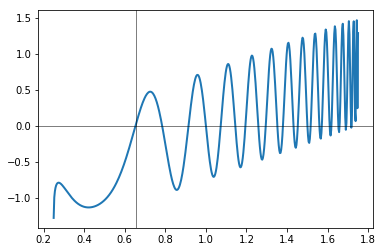

In [7]:
# Plot Omega_fun (using inverse of Delta)
Omega_arr = np.linspace(w0 - g/2, w0 + g/2, num=500)
err_fun = np.zeros(Omega_arr.size)

for j in range(err_fun.size):
    err_fun[j] = Omega_fun(Omega_arr[j])

# PLOT
fig, ax = plt.subplots(1,1)
ax.plot(Omega_arr, err_fun, **pltopts)
ax.axhline(y=0, color='black', linewidth=0.5)
ax.axvline(x=Omega, color='black', linewidth=0.5)

## Eigenvalues (plot)

Minimum of F(y) = 1.5265566588595902e-15


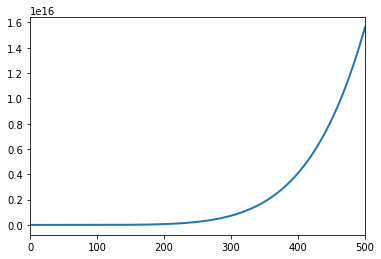

In [14]:
# Define F(y) = |P(iy)| - |Q(iy)| (not likely to work out, better to just draw heat map)
Omega0 = Omega
Delta0 = asy_phases[1] - asy_phases[0]

# Other harmonics
Omega_sol = Omega_roots[0]
Delta_sol = Delta_roots[0]

eigen_poly = lambda z: funlib.eig2D_det(z, Omega_sol, Delta_sol, tau0, sol)
F_y = lambda y: funlib.abs_diff(eigen_poly(1j*y))

# Define arrays
yf = 500
y_arr = np.linspace(0, yf, num=10000)
F_arr = np.zeros(y_arr.size)

for j in range(y_arr.size):
    F_arr[j] = F_y(y_arr[j])

# Find global minimum
F_min = np.min(F_arr)
print("Minimum of F(y) = " + str(F_min))

# Plot
fig, ax = plt.subplots(1,1)

ax.set_xlim(left=0, right=yf)
ax.plot(y_arr, F_arr, **pltopts)

# Eigenvalue roots of exponential polynomial (heatmap)

Theoretical freq = 0.6533032016346197
Theoretical phase diff = 0.4805448631509235


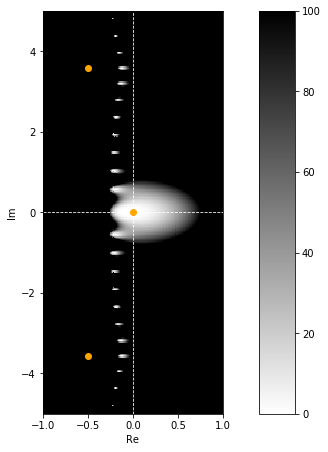

In [21]:
# Print chosen roots
print("Theoretical freq = " + str(Omega_sol))
print("Theoretical phase diff = " + str(Delta_sol))

# Polynomial roots (without delay)
quart_coeffs = funlib.eig2D_cubic(Omega_sol, Delta_sol, tau0, sol)

# Plot root branch functions with respect to gain, tau0.
# quart_roots = funlib.quartic_roots(quart_coeffs)
cubic_roots_np = np.roots(quart_coeffs)

# Root points
quart_roots_re = np.real(cubic_roots_np)
quart_roots_im = np.imag(cubic_roots_np)

# Generate error mesh
u_R, v_R = 1,5
part_u, part_v = 300, 300

u_lin = np.linspace(-u_R, u_R, num=part_u)
v_lin = np.linspace(-v_R, v_R, num=part_v)

v_mesh, u_mesh = np.meshgrid(v_lin, u_lin)

err_mesh = np.zeros(u_mesh.shape)
for k in range(u_lin.size):
    for l in range(v_lin.size):
        err_mesh[k,l] = np.min((np.abs(eigen_poly(u_mesh[k,l] + 1j*v_mesh[k,l])[3]), 100))

# Transform err_mesh
z_mesh = err_mesh**2

# The bounds for z_array:
abs_max = np.abs(err_mesh).max() #int(abs_max + 1)
z_min, z_max = 0, abs_max

# Set the limits of the plot to the limits of the data
u_min = u_mesh.min()
u_max = u_mesh.max()
v_min = v_mesh.min()
v_max = v_mesh.max()
    
# Plot
fig, ax = plt.subplots(2, figsize=(5,7))

# [left, bottom, width, height] 
bbox0 = [0.1, 0.1, 0.5, 0.8]
bbox1 = [0.7, 0.1, 0.1, 0.8]

# Set ax positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)

ax[0].set_xlabel("Re")
ax[0].set_ylabel("Im")

c = ax[0].pcolormesh(u_mesh, v_mesh, z_mesh, cmap='binary', vmin=z_min, vmax=z_max) # cmap='RdBu'
ax[0].axis([u_min, u_max, v_min, v_max])
    
# x,y-axis
line_opt = {'linestyle': 'dashed',
            'linewidth': 0.8,
            'color': 'white'
            }

ax[0].axhline(y=0, **line_opt)
ax[0].axvline(x=0, **line_opt)

# Plot polynomial roots
ax[0].plot(quart_roots_re, 
           quart_roots_im,
           linestyle='None',
           marker='o',
           markersize=6,
           
           color='orange')

# Colourbar
fig.colorbar(c, cax=ax[1]) 

## Eigenvalue roots of quartic polynomial

In [16]:
# Obtain roots of quartic polynomial.
cubic_coeffs = funlib.eig2D_cubic(Omega_sol, Delta_sol, tau0, sol)

# Plot root branch functions with respect to gain, tau0.
# quart_roots = funlib.quartic_roots(quart_coeffs)
cubic_roots_np = np.roots(cubic_coeffs)

zero = eigen_poly(cubic_roots_np[0])[4]
zero2 = eigen_poly(cubic_roots_np[2])[4]
print(cubic_roots_np)
print("Root formula correct: " + str(np.abs(zero)))
print("Root formula correct: " + str(np.abs(zero2)))

[-0.5+3.57554522j -0.5-3.57554522j  0. +0.j        ]
Root formula correct: 2.881194528881009e-14
Root formula correct: 1.7208456881689926e-15


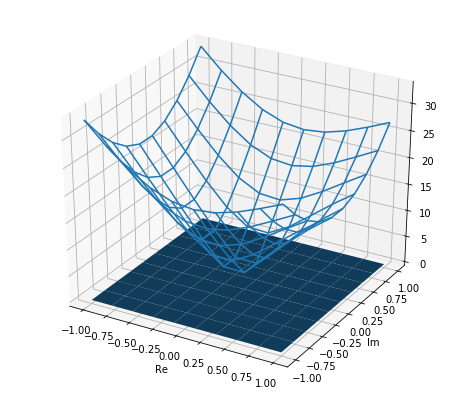

In [11]:
u_R, v_R = 1, 1

u_lin = np.linspace(-u_R, u_R, num=10)
v_lin = np.linspace(-v_R, v_R, num=10)

v_mesh, u_mesh = np.meshgrid(v_lin, u_lin)

c_mesh = np.zeros(u_mesh.shape)
for k in range(u_lin.size):
    for l in range(v_lin.size):
        c_mesh[k,l] = np.min((np.abs(eigen_poly(u_mesh[k,l] + 1j*v_mesh[k,l])[3]), 100))

# Plot
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("Re")
ax.set_ylabel("Im")

ax.plot_wireframe(u_mesh, v_mesh, c_mesh)
ax.plot_surface(u_mesh, v_mesh, np.zeros(u_mesh.shape))